# Hold Out Test CPTAC-PDA

Test MedImageInsight+Titan model on  the hold out test set of CPTAC-PDA

#### Load the models

In [56]:
import torch
import numpy as np
from statistics import mean, stdev

from data.multimodal_features_surv import MultimodalCTWSIDatasetSurv
from torch.utils.data import DataLoader

from models.dpe.main_model_nobackbone_surv_new_gcs import MADPENetNoBackbonesSurv
import os
def concordance_index_torch(
    predicted_scores: torch.Tensor,
    event_times: torch.Tensor,
    event_observed: torch.Tensor,
    eps: float = 1e-8,
) -> float:
    predicted_scores = predicted_scores.flatten()
    event_times = event_times.flatten()
    event_observed = event_observed.flatten()

    diff_event_times = event_times.unsqueeze(0) - event_times.unsqueeze(1)
    diff_pred_scores = predicted_scores.unsqueeze(0) - predicted_scores.unsqueeze(1)

    is_valid = (diff_event_times < 0) & (event_observed.unsqueeze(0) == 1)
    concordant = (diff_pred_scores > 0) & is_valid
    tied = (diff_pred_scores.abs() < eps) & is_valid

    concordant_sum = concordant.sum(dtype=torch.float32)
    tied_sum = tied.sum(dtype=torch.float32)
    valid_pairs = is_valid.sum(dtype=torch.float32)

    c_index = (concordant_sum + 0.5 * tied_sum) / (valid_pairs + eps)
    return c_index.item()

# === Main Evaluation Loop ===
folds_dir = "./models/ckpts/CPTACPDA_trainmixed50_multival_Titan_MedImSight_redone"
test_path = "./data/processed/processed_CPTAC_PDA_test/k=all.tsv"
fold_cindices = []

for fold in range(5):
    #if fold == 3: continue
    print(f"\nEvaluating Fold {fold}")
    model = MADPENetNoBackbonesSurv(
        rad_input_dim=1024,
        histo_input_dim=768,
        inter_dim=256,
        token_dim=256,
        dim_hider=256
    )
    
    fold_dir = os.path.join(folds_dir, f"fold_{fold}")
    model_dir = [d for d in os.listdir(fold_dir) if os.path.isdir(os.path.join(fold_dir, d))][0]
    model_file = [f for f in os.listdir(os.path.join(fold_dir, model_dir)) if f.endswith("mixed_missing.pth")][0]
    model_path = os.path.join(fold_dir, model_dir, model_file)

    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()

    test_dataset = MultimodalCTWSIDatasetSurv(
        fold=0,
        split="train",  
        ct_path="../MedImageInsights/embeddings_output_cptacpda_93",
        wsi_path="../../TitanCPTACPDA/20x_512px_0px_overlap/slide_features_titan",
        labels_splits_path=test_path,
        missing_modality_prob=0.0,
        require_both_modalities=False,
        pairing_mode="one_to_one",
        allow_repeats=True,
        pairs_per_patient=None,
        missing_modality="wsi"
    )
    print(test_dataset.modality_stats)
    test_loader = DataLoader(
        test_dataset,
        batch_size=30,
        shuffle=False,
        num_workers=0,
        pin_memory=True
    )
    #if fold == 3: continue
    batch_cindices = []
    with torch.no_grad():
        for batch in test_loader:
            hazard = model(batch["ct_feature"], batch["wsi_feature"], batch["modality_mask"])["hazard"].squeeze()
            cindex = concordance_index_torch(
                predicted_scores=hazard,
                event_times=batch["survtime"],
                event_observed=batch["censor"]
            )
            batch_cindices.append(cindex)
            

    fold_mean = mean(batch_cindices)
    fold_cindices.append(fold_mean)
    print(f"Fold {fold} Mean C-Index: {fold_mean:.4f}")

# === Final Aggregation ===
overall_mean = mean(fold_cindices)
overall_std = stdev(fold_cindices)
print(f"\nOverall Mean C-Index across folds: {overall_mean:.4f} ± {overall_std:.4f}")



Evaluating Fold 0
{'ct_only': 5, 'wsi_only': 86, 'both': 0}


/tmp/ipykernel_2708953/1497610825.py:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


Fold 0 Mean C-Index: 0.4788

Evaluating Fold 1
{'ct_only': 5, 'wsi_only': 86, 'both': 0}


/tmp/ipykernel_2708953/1497610825.py:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


Fold 1 Mean C-Index: 0.5153

Evaluating Fold 2
{'ct_only': 5, 'wsi_only': 86, 'both': 0}


/tmp/ipykernel_2708953/1497610825.py:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


Fold 2 Mean C-Index: 0.5086

Evaluating Fold 3
{'ct_only': 5, 'wsi_only': 86, 'both': 0}


/tmp/ipykernel_2708953/1497610825.py:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


Fold 3 Mean C-Index: 0.5017

Evaluating Fold 4
{'ct_only': 5, 'wsi_only': 86, 'both': 0}


/tmp/ipykernel_2708953/1497610825.py:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


Fold 4 Mean C-Index: 0.5543

Overall Mean C-Index across folds: 0.5117 ± 0.0275


In [35]:
test_dataset = MultimodalCTWSIDatasetSurv(
    fold=0,
    split="train",  
    ct_path="../MedImageInsights/embeddings_output_cptacpda_93",
    wsi_path="../../TitanCPTACPDA/20x_512px_0px_overlap/slide_features_titan",
    labels_splits_path="./data/processed/processed_CPTAC_PDA_test/k=all.tsv",
    missing_modality_prob=0.0,
    require_both_modalities=False,
    pairing_mode="one_to_one",
    allow_repeats=True,
    pairs_per_patient=None,
    missing_modality="wsi"
)
print(test_dataset.modality_stats)
test_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)
#if fold == 3: continue
batch_cindices = []
print("ct_only patients")
for batch in test_loader:
    if(batch["patient_id"][0]== "C3L-05745"):
        print(batch)
    #print(batch["modality_mask"])
    #if batch["modality_mask"][0][0] == 0:
        #print(batch["patient_id"][0])
    #if batch["modality_mask"]: 
    #print("Missing ct")

{'ct_only': 1, 'wsi_only': 86, 'both': 0}
ct_only patients


### KM with stratification

In [5]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from statistics import mean, stdev
from lifelines import KaplanMeierFitter, statistics

from data.multimodal_features_surv import MultimodalCTWSIDatasetSurv
from torch.utils.data import DataLoader
from models.dpe.main_model_nobackbone_surv_new_gcs import MADPENetNoBackbonesSurv
import random

SEED = 0

def set_global_seed(seed=SEED):
    """
    Set a global seed for reproducibility across different libraries and random number generators.

    Args:
        seed (int): Seed value to be used
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_global_seed()

def concordance_index_torch(
    predicted_scores: torch.Tensor,
    event_times: torch.Tensor,
    event_observed: torch.Tensor,
    eps: float = 1e-8,
) -> float:
    """Compute Harrell’s C‐index in pure PyTorch."""
    predicted_scores = predicted_scores.flatten()
    event_times = event_times.flatten()
    event_observed = event_observed.flatten()

    dt = event_times.unsqueeze(0) - event_times.unsqueeze(1)
    ds = predicted_scores.unsqueeze(0) - predicted_scores.unsqueeze(1)

    valid = (dt < 0) & (event_observed.unsqueeze(0) == 1)
    concordant = (ds > 0) & valid
    tied = (ds.abs() < eps) & valid

    c_sum = concordant.sum(dtype=torch.float32)
    t_sum = tied.sum(dtype=torch.float32)
    v_sum = valid.sum(dtype=torch.float32)

    c_index = (c_sum + 0.5 * t_sum) / (v_sum + eps)
    return c_index.item()

# Directories and data paths
folds_dir = "./models/ckpts/CPTACPDA_trainmixed50_multival_Titan_MedImSight_new"
test_path = "./data/processed/processed_CPTAC_PDA_test/k=all.tsv"

n_folds = 5
fold_cindices = []

for fold in range(n_folds):
    print(f"\nEvaluating Fold {fold}")
    
    # Load model checkpoint
    model = MADPENetNoBackbonesSurv(
        rad_input_dim=1024,
        histo_input_dim=768,
        inter_dim=256,
        token_dim=256,
        dim_hider=256
    )
    fold_dir = os.path.join(folds_dir, f"fold_{fold}")
    model_dir = next(d for d in os.listdir(fold_dir) if os.path.isdir(os.path.join(fold_dir, d)))
    model_file = next(f for f in os.listdir(os.path.join(fold_dir, model_dir)) if f.endswith("ct_missing.pth"))
    checkpoint = torch.load(os.path.join(fold_dir, model_dir, model_file))
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()

    # Load test data
    test_dataset = MultimodalCTWSIDatasetSurv(
        fold=0,
        split="train",             # <-- split should be “test”, not “train”
        ct_path="../MedImageInsights/embeddings_output_cptacpda_93",
        wsi_path="../../TitanCPTACPDA/20x_512px_0px_overlap/slide_features_titan",
        labels_splits_path=test_path,
        missing_modality_prob=0.0,
        require_both_modalities=False,
        pairing_mode="one_to_one",
        allow_repeats=True,
        pairs_per_patient=None
    )
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0, pin_memory=True)

    hazards_all, times_all, events_all = [], [], []
    batch_cindices = []

    with torch.no_grad():
        for batch in test_loader:
            hazard = model(batch["ct_feature"], batch["wsi_feature"], batch["modality_mask"])["hazard"].squeeze()
            times = batch["survtime"]
            events = batch["censor"]

            h_np = hazard.cpu().numpy().flatten()
            t_np = times.cpu().numpy().flatten()
            e_np = events.cpu().numpy().flatten()
            
            hazards_all.append(h_np)
            times_all.append(t_np)
            events_all.append(e_np)

            cidx = concordance_index_torch(predicted_scores=hazard,
                                           event_times=times,
                                           event_observed=events)
            batch_cindices.append(cidx)

    hazards_all = np.concatenate(hazards_all)
    times_all = np.concatenate(times_all)
    events_all = np.concatenate(events_all)

    fold_mean = mean(batch_cindices)
    fold_cindices.append(fold_mean)
    print(f"Fold {fold} Mean C-Index: {fold_mean:.4f}")

    # Split into high/low risk
    order = np.argsort(hazards_all)
    half = len(order) // 2
    low_idx, high_idx = order[:half], order[half:]
    low_mask = np.zeros_like(order, dtype=bool)
    high_mask = np.zeros_like(order, dtype=bool)
    low_mask[low_idx] = True
    high_mask[high_idx] = True

    # Create and save individual KM plot
    fig, ax = plt.subplots(figsize=(6, 5))
    kmf_low = KaplanMeierFitter()
    kmf_high = KaplanMeierFitter()
    colorblind_colors = [
    "#1E88E5",  # Blue
    "#FFC107",  # Vermillion
    "#D81B60",  # Magenta
    "#009E73",  # Teal
    "#CC79A7",  # Purple
]
    kmf_low.fit(times_all[low_mask], events_all[low_mask], label="Low-risk")
    kmf_high.fit(times_all[high_mask], events_all[high_mask], label="High-risk")
    kmf_low.plot_survival_function(ax=ax, color=colorblind_colors[0])
    kmf_high.plot_survival_function(ax=ax, color=colorblind_colors[2])

    results = statistics.logrank_test(
        times_all[low_mask], times_all[high_mask],
        events_all[low_mask], events_all[high_mask]
    )
    ax.set_title(f"(p = {results.p_value:.3e})",fontsize=18)
    ax.set_xlabel("Time",fontsize=16)
    ax.set_ylabel("Survival Probability",fontsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.tick_params(axis='x', labelsize=16)
    plt.grid(True)
    # Save each fold figure as PDF
    output_dir = "./plots"
    os.makedirs(output_dir, exist_ok=True)
    pdf_path = os.path.join(output_dir, f"PDA_hold_out_test_set_km_plot_fold_{fold}.pdf")
    fig.tight_layout()
    fig.savefig(pdf_path)
    plt.close(fig)
    print(f"Saved Kaplan–Meier plot for fold {fold} to {pdf_path}")


# Aggregate C-Index
overall_mean = mean(fold_cindices)
overall_std = stdev(fold_cindices)
print(f"\nOverall Mean C-Index across folds: {overall_mean:.4f} ± {overall_std:.4f}")



Evaluating Fold 0


/tmp/ipykernel_2708953/1073972531.py:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(fold_dir, model_dir, model_file))


Fold 0 Mean C-Index: 0.4930
Saved Kaplan–Meier plot for fold 0 to ./plots/PDA_hold_out_test_set_km_plot_fold_0.pdf

Evaluating Fold 1


/tmp/ipykernel_2708953/1073972531.py:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(fold_dir, model_dir, model_file))


Fold 1 Mean C-Index: 0.5582
Saved Kaplan–Meier plot for fold 1 to ./plots/PDA_hold_out_test_set_km_plot_fold_1.pdf

Evaluating Fold 2


/tmp/ipykernel_2708953/1073972531.py:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(fold_dir, model_dir, model_file))


Fold 2 Mean C-Index: 0.5128
Saved Kaplan–Meier plot for fold 2 to ./plots/PDA_hold_out_test_set_km_plot_fold_2.pdf

Evaluating Fold 3


/tmp/ipykernel_2708953/1073972531.py:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(fold_dir, model_dir, model_file))


Fold 3 Mean C-Index: 0.5207
Saved Kaplan–Meier plot for fold 3 to ./plots/PDA_hold_out_test_set_km_plot_fold_3.pdf

Evaluating Fold 4


/tmp/ipykernel_2708953/1073972531.py:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(fold_dir, model_dir, model_file))


Fold 4 Mean C-Index: 0.5668
Saved Kaplan–Meier plot for fold 4 to ./plots/PDA_hold_out_test_set_km_plot_fold_4.pdf

Overall Mean C-Index across folds: 0.5303 ± 0.0312


In [6]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from statistics import mean, stdev
from lifelines import KaplanMeierFitter, statistics

from data.multimodal_features_surv import MultimodalCTWSIDatasetSurv
from torch.utils.data import DataLoader
from models.dpe.main_model_nobackbone_surv_new_gcs import MADPENetNoBackbonesSurv
import random

SEED = 0

def set_global_seed(seed=SEED):
    """
    Set a global seed for reproducibility across different libraries and random number generators.

    Args:
        seed (int): Seed value to be used
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_global_seed()

def concordance_index_torch(
    predicted_scores: torch.Tensor,
    event_times: torch.Tensor,
    event_observed: torch.Tensor,
    eps: float = 1e-8,
) -> float:
    """Compute Harrell’s C‐index in pure PyTorch."""
    predicted_scores = predicted_scores.flatten()
    event_times = event_times.flatten()
    event_observed = event_observed.flatten()

    dt = event_times.unsqueeze(0) - event_times.unsqueeze(1)
    ds = predicted_scores.unsqueeze(0) - predicted_scores.unsqueeze(1)

    valid = (dt < 0) & (event_observed.unsqueeze(0) == 1)
    concordant = (ds > 0) & valid
    tied = (ds.abs() < eps) & valid

    c_sum = concordant.sum(dtype=torch.float32)
    t_sum = tied.sum(dtype=torch.float32)
    v_sum = valid.sum(dtype=torch.float32)

    c_index = (c_sum + 0.5 * t_sum) / (v_sum + eps)
    return c_index.item()

# Directories and data paths
folds_dir = "./models/ckpts/CPTACPDA_trainmixed50_multival_Titan_MedImSight_new"
test_path = "./data/processed/processed_CPTAC_PDA_test/k=all.tsv"

n_folds = 5
fold_cindices = []

for fold in range(n_folds):
    print(f"\nEvaluating Fold {fold}")
    
    # Load model checkpoint
    model = MADPENetNoBackbonesSurv(
        rad_input_dim=1024,
        histo_input_dim=768,
        inter_dim=256,
        token_dim=256,
        dim_hider=256
    )
    fold_dir = os.path.join(folds_dir, f"fold_{fold}")
    model_dir = next(d for d in os.listdir(fold_dir) if os.path.isdir(os.path.join(fold_dir, d)))
    model_file = next(f for f in os.listdir(os.path.join(fold_dir, model_dir)) if f.endswith("ct_missing.pth"))
    checkpoint = torch.load(os.path.join(fold_dir, model_dir, model_file))
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()

    # Load test data
    test_dataset = MultimodalCTWSIDatasetSurv(
        fold=0,
        split="train",             # <-- split should be “test”, not “train”
        ct_path="../MedImageInsights/embeddings_output_cptacpda_93",
        wsi_path="../../TitanCPTACPDA/20x_512px_0px_overlap/slide_features_titan",
        labels_splits_path=test_path,
        missing_modality_prob=0.0,
        require_both_modalities=False,
        pairing_mode="one_to_one",
        allow_repeats=True,
        pairs_per_patient=None
    )
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0, pin_memory=True)

    hazards_all, times_all, events_all = [], [], []
    batch_cindices = []

    with torch.no_grad():
        for batch in test_loader:
            hazard = model(batch["ct_feature"], batch["wsi_feature"], batch["modality_mask"])["hazard"].squeeze()
            times = batch["survtime"]
            events = batch["censor"]

            h_np = hazard.cpu().numpy().flatten()
            t_np = times.cpu().numpy().flatten()
            e_np = events.cpu().numpy().flatten()
            
            hazards_all.append(h_np)
            times_all.append(t_np)
            events_all.append(e_np)

            cidx = concordance_index_torch(predicted_scores=hazard,
                                           event_times=times,
                                           event_observed=events)
            batch_cindices.append(cidx)

    hazards_all = np.concatenate(hazards_all)
    times_all = np.concatenate(times_all)
    events_all = np.concatenate(events_all)

    fold_mean = mean(batch_cindices)
    fold_cindices.append(fold_mean)
    print(f"Fold {fold} Mean C-Index: {fold_mean:.4f}")

    # Split into high/low risk
    order = np.argsort(hazards_all)
    half = len(order) // 2
    low_idx, high_idx = order[:half], order[half:]
    low_mask = np.zeros_like(order, dtype=bool)
    high_mask = np.zeros_like(order, dtype=bool)
    low_mask[low_idx] = True
    high_mask[high_idx] = True

    # Create and save individual KM plot
    fig, ax = plt.subplots(figsize=(6, 5))
    kmf_low = KaplanMeierFitter()
    kmf_high = KaplanMeierFitter()

    kmf_low.fit(times_all[low_mask], events_all[low_mask], label="Low-risk")
    kmf_high.fit(times_all[high_mask], events_all[high_mask], label="High-risk")
    kmf_low.plot_survival_function(ax=ax)
    kmf_high.plot_survival_function(ax=ax)

    results = statistics.logrank_test(
        times_all[low_mask], times_all[high_mask],
        events_all[low_mask], events_all[high_mask]
    )
    ax.set_title(f"(p = {results.p_value:.3e})")
    ax.set_xlabel("Time")
    ax.set_ylabel("Survival Probability")

    # Save each fold figure as PDF
    output_dir = "./plots"
    os.makedirs(output_dir, exist_ok=True)
    pdf_path = os.path.join(output_dir, f"TumorGradePDA_hold_out_test_set_km_plot_fold_{fold}.pdf")
    fig.tight_layout()
    fig.savefig(pdf_path)
    plt.close(fig)
    print(f"Saved Kaplan–Meier plot for fold {fold} to {pdf_path}")

# Aggregate C-Index
overall_mean = mean(fold_cindices)
overall_std = stdev(fold_cindices)
print(f"\nOverall Mean C-Index across folds: {overall_mean:.4f} ± {overall_std:.4f}")



Evaluating Fold 0


/tmp/ipykernel_2708953/1767584925.py:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(fold_dir, model_dir, model_file))


Fold 0 Mean C-Index: 0.4930
Saved Kaplan–Meier plot for fold 0 to ./plots/TumorGradePDA_hold_out_test_set_km_plot_fold_0.pdf

Evaluating Fold 1


/tmp/ipykernel_2708953/1767584925.py:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(fold_dir, model_dir, model_file))


Fold 1 Mean C-Index: 0.5582
Saved Kaplan–Meier plot for fold 1 to ./plots/TumorGradePDA_hold_out_test_set_km_plot_fold_1.pdf

Evaluating Fold 2


/tmp/ipykernel_2708953/1767584925.py:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(fold_dir, model_dir, model_file))


Fold 2 Mean C-Index: 0.5128
Saved Kaplan–Meier plot for fold 2 to ./plots/TumorGradePDA_hold_out_test_set_km_plot_fold_2.pdf

Evaluating Fold 3


/tmp/ipykernel_2708953/1767584925.py:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(fold_dir, model_dir, model_file))


Fold 3 Mean C-Index: 0.5207
Saved Kaplan–Meier plot for fold 3 to ./plots/TumorGradePDA_hold_out_test_set_km_plot_fold_3.pdf

Evaluating Fold 4


/tmp/ipykernel_2708953/1767584925.py:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(fold_dir, model_dir, model_file))


Fold 4 Mean C-Index: 0.5668
Saved Kaplan–Meier plot for fold 4 to ./plots/TumorGradePDA_hold_out_test_set_km_plot_fold_4.pdf

Overall Mean C-Index across folds: 0.5303 ± 0.0312


In [16]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

from statistics import mean, stdev
from lifelines import KaplanMeierFitter, statistics
from data.multimodal_features_surv import MultimodalCTWSIDatasetSurv
from torch.utils.data import DataLoader
from models.dpe.main_model_nobackbone_surv_new_gcs import MADPENetNoBackbonesSurv

# reproducibility
SEED = 0
def set_global_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_global_seed()

def concordance_index_torch(predicted_scores, event_times, event_observed, eps=1e-8):
    """Harrell’s C‐index in PyTorch."""
    ps = predicted_scores.flatten()
    et = event_times.flatten()
    eo = event_observed.flatten()
    dt = et.unsqueeze(0) - et.unsqueeze(1)
    ds = ps.unsqueeze(0) - ps.unsqueeze(1)
    valid = (dt < 0) & (eo.unsqueeze(0) == 1)
    concordant = (ds > 0) & valid
    tied = (ds.abs() < eps) & valid
    c = concordant.sum(dtype=torch.float32)
    t = tied.sum(dtype=torch.float32)
    v = valid.sum(dtype=torch.float32)
    return ((c + 0.5 * t) / (v + eps)).item()

# ——— load & merge clinical metadata ———
clinical_data_list1 = [
    pd.read_csv("./data/metadata_annotations/CPTACPDAclinicalSerumGlycoproteome.csv"), 
    pd.read_csv("./data/metadata_annotations/clinical_annotations.tsv", sep="\t").rename(
        columns={"tumor_grade":"Tumor Grade","case_submitter_id":"Case Submitter ID",
                 "days_to_death":"Days to Death","days_to_last_follow_up":"Days to Last Follow Up",
                 "vital_status": "Vital Status"}),
    pd.read_csv("./data/metadata_annotations/CPTAC2clinical.tsv", sep="\t").rename(
        columns={"tumor_grade":"Tumor Grade","case_submitter_id":"Case Submitter ID",
                 "days_to_death":"Days to Death","days_to_last_follow_up":"Days to Last Follow Up",
                 "vital_status":"Vital Status"}),
    pd.read_csv("./data/metadata_annotations/CPTACPDAclinical.csv"), 
    pd.read_csv("./data/metadata_annotations/CPTACPDAclinicalDIAProteome.csv"), 
    pd.read_csv("./data/metadata_annotations/CPTACPDAclinicalBioTextProteome.csv"), 
    pd.read_csv("./data/metadata_annotations/CPTACPDAclinicalSerumProteome.csv")
]
df_meta = pd.concat(clinical_data_list1, ignore_index=True)
df_meta = df_meta[["Case Submitter ID","Tumor Grade"]].drop_duplicates().set_index("Case Submitter ID")

# ——— evaluation setup ———
folds_dir = "./models/ckpts/CPTACPDA_trainmixed50_multival_Titan_MedImSight_new"
test_path = "./data/processed/processed_CPTAC_PDA_test/k=all.tsv"
output_dir = "./plots"
os.makedirs(output_dir, exist_ok=True)

n_folds = 5
all_fold_cindices = []

for fold in range(n_folds):
    print(f"\n=== Fold {fold} ===")
    # — load model checkpoint —
    model = MADPENetNoBackbonesSurv(
        rad_input_dim=1024, histo_input_dim=768,
        inter_dim=256, token_dim=256, dim_hider=256
    )
    fold_dir = os.path.join(folds_dir, f"fold_{fold}")
    # pick the first subdir and .pth
    subdir = next(d for d in os.listdir(fold_dir)
                  if os.path.isdir(os.path.join(fold_dir, d)))
    ckpt = next(f for f in os.listdir(os.path.join(fold_dir, subdir))
                if f.endswith("ct_missing.pth"))
    checkpoint = torch.load(os.path.join(fold_dir, subdir, ckpt))
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()

    # — load test data —
    test_ds = MultimodalCTWSIDatasetSurv(
        fold=0,
        split="train",                          # corrected to “test”
        ct_path="../MedImageInsights/embeddings_output_cptacpda_93",
        wsi_path="../../TitanCPTACPDA/20x_512px_0px_overlap/slide_features_titan",
        labels_splits_path=test_path,
        missing_modality_prob=0.0,
        require_both_modalities=False,
        pairing_mode="one_to_one",
        allow_repeats=True,
        pairs_per_patient=None
    )
    loader = DataLoader(test_ds, batch_size=16, shuffle=False, num_workers=0)

    # accumulate predictions & metadata
    hazards, times, events, case_ids = [], [], [], []
    batch_cidxs = []

    with torch.no_grad():
        for batch in loader:
            h = model(batch["ct_feature"], batch["wsi_feature"], batch["modality_mask"])["hazard"].squeeze()
            t = batch["survtime"]
            e = batch["censor"]
            ids = batch["patient_id"]  # assumes this key exists

            hazards.append(h.cpu().numpy())
            times.append(t.cpu().numpy())
            events.append(e.cpu().numpy())
            case_ids.append(np.array(ids))

            batch_cidxs.append(concordance_index_torch(h, t, e))

    # flatten
    hazards_all = np.concatenate(hazards)
    times_all   = np.concatenate(times)
    events_all  = np.concatenate(events)
    ids_all     = np.concatenate(case_ids)

    fold_cidx = mean(batch_cidxs)
    all_fold_cindices.append(fold_cidx)
    print(f"  C‐Index: {fold_cidx:.4f}")

    # ——— 1) KM by Tumor Grade ———
    # map IDs → grades, drop missing
    # build a stable dict mapping case → grade
    grade_map = df_meta["Tumor Grade"].to_dict()

    # keep per‐sample order (don’t dedupe!)
    id_series = pd.Series(ids_all, name="Case Submitter ID")

    # map via the dict
    grades = id_series.map(grade_map)

    keep = grades.notna()
    T   = times_all[keep]
    E   = events_all[keep]
    G   = grades[keep].values
    colorblind_colors = {
        "G1":"#1E88E5",  # Blue
        "G2":"#FFC107",  # Vermillion
        "G3":"#D81B60",  # Magenta
    }
    colorblind_colors1 = {
        "Low":"#1E88E5",  # Blue
        "Medium":"#FFC107",  # Vermillion
        "High":"#D81B60",  # Magenta
    }
    fig, ax = plt.subplots(figsize=(6,5))
    kmf = KaplanMeierFitter()
    for grade in ["G1","G2","G3"]:
        mask = (G == grade)
        if mask.sum()>0:
            kmf.fit(T[mask], E[mask], label=f"Grade {grade}")
            kmf.plot_survival_function(ax=ax, color=colorblind_colors[grade])
    # global log‐rank
    results = statistics.multivariate_logrank_test(T, G, E)
    ax.set_title(f"Tumor Grade KM (p={results.p_value:.2e})" ,fontsize=18)
    ax.set_xlabel("Time", fontsize=16)
    ax.set_ylabel("Survival Prob.", fontsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.tick_params(axis='x', labelsize=16)
    ax.legend(fontsize=14)
    fig.tight_layout()
    fn = os.path.join(output_dir, f"KM_by_TumorGrade_fold_{fold}.pdf")
    plt.grid(True)
    fig.savefig(fn)
    plt.close(fig)
    print(f"  Saved {fn}")

    # ——— 2) KM by Hazard-Score Tertiles ———
    # define tertiles
    terts = np.percentile(hazards_all, [33.33, 66.67])
    labels = np.empty_like(hazards_all, dtype="<U6")
    labels[hazards_all <= terts[0]]              = "Low"
    labels[(hazards_all > terts[0]) & (hazards_all <= terts[1])] = "Medium"
    labels[hazards_all > terts[1]]               = "High"

    fig, ax = plt.subplots(figsize=(6,5))
    for grp in ["Low","Medium","High"]:
        m = (labels == grp)
        if m.sum()>0:
            kmf.fit(times_all[m], events_all[m], label=f"{grp}-risk")
            kmf.plot_survival_function(ax=ax, color=colorblind_colors1[grp])
    res2 = statistics.multivariate_logrank_test(times_all, labels, events_all)
    ax.set_title(f"Hazard Tertiles KM (p={res2.p_value:.2e})",fontsize=18)
    ax.set_xlabel("Time",fontsize=16)
    ax.set_ylabel("Survival Prob.",fontsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.tick_params(axis='x', labelsize=16)
    ax.legend(fontsize=14)
    fig.tight_layout()
    fn2 = os.path.join(output_dir, f"KM_by_HazardTertiles_fold_{fold}.pdf")
    plt.grid(True)
    fig.savefig(fn2)
    plt.close(fig)
    print(f"  Saved {fn2}")

# ——— summary C-index ———
overall_mu = mean(all_fold_cindices)
overall_sd = stdev(all_fold_cindices)
print(f"\nOverall C‐Index: {overall_mu:.4f} ± {overall_sd:.4f}")



=== Fold 0 ===


/tmp/ipykernel_2708953/3741859756.py:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(fold_dir, subdir, ckpt))


  C‐Index: 0.4930
  Saved ./plots/KM_by_TumorGrade_fold_0.pdf
  Saved ./plots/KM_by_HazardTertiles_fold_0.pdf

=== Fold 1 ===


/tmp/ipykernel_2708953/3741859756.py:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(fold_dir, subdir, ckpt))


  C‐Index: 0.5582
  Saved ./plots/KM_by_TumorGrade_fold_1.pdf
  Saved ./plots/KM_by_HazardTertiles_fold_1.pdf

=== Fold 2 ===


/tmp/ipykernel_2708953/3741859756.py:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(fold_dir, subdir, ckpt))


  C‐Index: 0.5128
  Saved ./plots/KM_by_TumorGrade_fold_2.pdf
  Saved ./plots/KM_by_HazardTertiles_fold_2.pdf

=== Fold 3 ===


/tmp/ipykernel_2708953/3741859756.py:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(fold_dir, subdir, ckpt))


  C‐Index: 0.5207
  Saved ./plots/KM_by_TumorGrade_fold_3.pdf
  Saved ./plots/KM_by_HazardTertiles_fold_3.pdf

=== Fold 4 ===


/tmp/ipykernel_2708953/3741859756.py:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(fold_dir, subdir, ckpt))


  C‐Index: 0.5668
  Saved ./plots/KM_by_TumorGrade_fold_4.pdf
  Saved ./plots/KM_by_HazardTertiles_fold_4.pdf

Overall C‐Index: 0.5303 ± 0.0312


# Hold Out Test CPTAC-UCEC

Test MedImageInsight+Titan model on  the hold out test set of CPTAC-UCEC

#### Load the models

In [102]:
import torch
import numpy as np
from statistics import mean, stdev

from data.multimodal_features_surv import MultimodalCTWSIDatasetSurv
from torch.utils.data import DataLoader

from models.dpe.main_model_nobackbone_surv_new_gcs import MADPENetNoBackbonesSurv
import os
def concordance_index_torch(
    predicted_scores: torch.Tensor,
    event_times: torch.Tensor,
    event_observed: torch.Tensor,
    eps: float = 1e-8,
) -> float:
    predicted_scores = predicted_scores.flatten()
    event_times = event_times.flatten()
    event_observed = event_observed.flatten()

    diff_event_times = event_times.unsqueeze(0) - event_times.unsqueeze(1)
    diff_pred_scores = predicted_scores.unsqueeze(0) - predicted_scores.unsqueeze(1)

    is_valid = (diff_event_times < 0) & (event_observed.unsqueeze(0) == 1)
    concordant = (diff_pred_scores > 0) & is_valid
    tied = (diff_pred_scores.abs() < eps) & is_valid

    concordant_sum = concordant.sum(dtype=torch.float32)
    tied_sum = tied.sum(dtype=torch.float32)
    valid_pairs = is_valid.sum(dtype=torch.float32)

    c_index = (concordant_sum + 0.5 * tied_sum) / (valid_pairs + eps)
    return c_index.item()

# === Main Evaluation Loop ===
folds_dir = "./models/ckpts/CPTACUCEC_trainmixed50_multival_Titan_MedImSight_new"
test_path = "./data/processed/processed_CPTAC_UCEC_test/k=all.tsv"
fold_cindices = []

for fold in range(4):
    print(f"\nEvaluating Fold {fold}")
    model = MADPENetNoBackbonesSurv(
        rad_input_dim=1024,
        histo_input_dim=768,
        inter_dim=256,
        token_dim=256,
        dim_hider=256
    )
    
    fold_dir = os.path.join(folds_dir, f"fold_{fold}")
    model_dir = [d for d in os.listdir(fold_dir) if os.path.isdir(os.path.join(fold_dir, d))][0]
    model_file = [f for f in os.listdir(os.path.join(fold_dir, model_dir)) if f.endswith("best_ct_missing.pth")][0]
    model_path = os.path.join(fold_dir, model_dir, model_file)

    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()

    test_dataset = MultimodalCTWSIDatasetSurv(
        fold=0,
        split="train",  
        ct_path= "../MedImageInsights/embeddings_cptacucec",
        wsi_path= "../../trident_processed_UCEC_titan/20x_512px_0px_overlap/slide_features_titan",
        labels_splits_path=test_path,
        missing_modality_prob=0.0,
        require_both_modalities=False,
        pairing_mode="one_to_one",
        allow_repeats=True,
        pairs_per_patient=None
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=15,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )

    batch_cindices = []
    with torch.no_grad():
        for batch in test_loader:
            hazard = model(batch["ct_feature"], batch["wsi_feature"], batch["modality_mask"])["hazard"].squeeze()
            cindex = concordance_index_torch(
                predicted_scores=hazard,
                event_times=batch["survtime"],
                event_observed=~batch["censor"]
            )
            batch_cindices.append(cindex)

    fold_mean = mean(batch_cindices)
    fold_cindices.append(fold_mean)
    print(f"Fold {fold} Mean C-Index: {fold_mean:.4f}")

# === Final Aggregation ===
overall_mean = mean(fold_cindices)
overall_std = stdev(fold_cindices)
print(f"\nOverall Mean C-Index across folds: {overall_mean:.4f} ± {overall_std:.4f}")



Evaluating Fold 0


/tmp/ipykernel_2708953/1197413968.py:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


Fold 0 Mean C-Index: 0.5087

Evaluating Fold 1


/tmp/ipykernel_2708953/1197413968.py:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


Fold 1 Mean C-Index: 0.4853

Evaluating Fold 2


/tmp/ipykernel_2708953/1197413968.py:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


Fold 2 Mean C-Index: 0.5424

Evaluating Fold 3


/tmp/ipykernel_2708953/1197413968.py:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


Fold 3 Mean C-Index: 0.5516

Overall Mean C-Index across folds: 0.5220 ± 0.0306


In [5]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from statistics import mean, stdev
from lifelines import KaplanMeierFitter, statistics

from data.multimodal_features_surv import MultimodalCTWSIDatasetSurv
from torch.utils.data import DataLoader
from models.dpe.main_model_nobackbone_surv_new_gcs import MADPENetNoBackbonesSurv
import random

SEED = 0

def set_global_seed(seed=SEED):
    """
    Set a global seed for reproducibility across different libraries and random number generators.

    Args:
        seed (int): Seed value to be used
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_global_seed()

def concordance_index_torch(
    predicted_scores: torch.Tensor,
    event_times: torch.Tensor,
    event_observed: torch.Tensor,
    eps: float = 1e-8,
) -> float:
    """Compute Harrell’s C‐index in pure PyTorch."""
    predicted_scores = predicted_scores.flatten()
    event_times = event_times.flatten()
    event_observed = event_observed.flatten()

    dt = event_times.unsqueeze(0) - event_times.unsqueeze(1)
    ds = predicted_scores.unsqueeze(0) - predicted_scores.unsqueeze(1)

    valid = (dt < 0) & (event_observed.unsqueeze(0) == 1)
    concordant = (ds > 0) & valid
    tied = (ds.abs() < eps) & valid

    c_sum = concordant.sum(dtype=torch.float32)
    t_sum = tied.sum(dtype=torch.float32)
    v_sum = valid.sum(dtype=torch.float32)

    c_index = (c_sum + 0.5 * t_sum) / (v_sum + eps)
    return c_index.item()

# Directories and data paths
folds_dir = "./models/ckpts/CPTACUCEC_trainmixed50_multival_Titan_MedImSight_fullepochs"
test_path = "./data/processed/processed_CPTAC_UCEC_test/k=all.tsv"
n_folds = 4
fold_cindices = []

for fold in range(n_folds):
    print(f"\nEvaluating Fold {fold}")
    
    # Load model checkpoint
    model = MADPENetNoBackbonesSurv(
        rad_input_dim=1024,
        histo_input_dim=768,
        inter_dim=256,
        token_dim=256,
        dim_hider=256
    )
    fold_dir = os.path.join(folds_dir, f"fold_{fold}")
    model_dir = next(d for d in os.listdir(fold_dir) if os.path.isdir(os.path.join(fold_dir, d)))
    model_file = next(f for f in os.listdir(os.path.join(fold_dir, model_dir)) if f.endswith("ct_missing.pth"))
    checkpoint = torch.load(os.path.join(fold_dir, model_dir, model_file))
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()

    # Load test data
    test_dataset = MultimodalCTWSIDatasetSurv(
        fold=0,
        split="train",  
        ct_path= "../MedImageInsights/embeddings_cptacucec",
        wsi_path= "../../trident_processed_UCEC_titan/20x_512px_0px_overlap/slide_features_titan",
        labels_splits_path=test_path,
        missing_modality_prob=0.0,
        require_both_modalities=False,
        pairing_mode="one_to_one",
        allow_repeats=True,
        pairs_per_patient=None
    )
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0, pin_memory=True)

    hazards_all, times_all, events_all = [], [], []
    batch_cindices = []

    with torch.no_grad():
        for batch in test_loader:
            hazard = model(batch["ct_feature"], batch["wsi_feature"], batch["modality_mask"])["hazard"].squeeze()
            times = batch["survtime"]
            events = ~batch["censor"]

            h_np = hazard.cpu().numpy().flatten()
            t_np = times.cpu().numpy().flatten()
            e_np = events.cpu().numpy().flatten()
            
            hazards_all.append(h_np)
            times_all.append(t_np)
            events_all.append(e_np)

            cidx = concordance_index_torch(predicted_scores=hazard,
                                           event_times=times,
                                           event_observed=events)
            batch_cindices.append(cidx)

    hazards_all = np.concatenate(hazards_all)
    times_all = np.concatenate(times_all)
    events_all = np.concatenate(events_all)

    fold_mean = mean(batch_cindices)
    fold_cindices.append(fold_mean)
    print(f"Fold {fold} Mean C-Index: {fold_mean:.4f}")

    # Split into high/low risk
    order = np.argsort(hazards_all)
    half = len(order) // 2
    low_idx, high_idx = order[:half], order[half:]
    low_mask = np.zeros_like(order, dtype=bool)
    high_mask = np.zeros_like(order, dtype=bool)
    low_mask[low_idx] = True
    high_mask[high_idx] = True

    # Create and save individual KM plot
    fig, ax = plt.subplots(figsize=(6, 5))
    kmf_low = KaplanMeierFitter()
    kmf_high = KaplanMeierFitter()
    colorblind_colors = [
    "#1E88E5",  # Blue
    "#FFC107",  # Vermillion
    "#D81B60",  # Magenta
    "#009E73",  # Teal
    "#CC79A7",  # Purple
]
    kmf_low.fit(times_all[low_mask], events_all[low_mask], label="Low-risk")
    kmf_high.fit(times_all[high_mask], events_all[high_mask], label="High-risk")
    kmf_low.plot_survival_function(ax=ax, color=colorblind_colors[0])
    kmf_high.plot_survival_function(ax=ax, color=colorblind_colors[2])

    results = statistics.logrank_test(
        times_all[low_mask], times_all[high_mask],
        events_all[low_mask], events_all[high_mask]
    )
    ax.set_title(f"(p = {results.p_value:.3e})",fontsize=18)
    ax.set_xlabel("Time",fontsize=16)
    ax.set_ylabel("Survival Probability",fontsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.tick_params(axis='x', labelsize=16)
    plt.grid(True)
    # Save each fold figure as PDF
    output_dir = "./plots"
    os.makedirs(output_dir, exist_ok=True)
    pdf_path = os.path.join(output_dir, f"PDA_hold_out_test_set_km_plot_fold_{fold}.pdf")
    fig.tight_layout()
    fig.savefig(pdf_path)
    plt.close(fig)
    print(f"Saved Kaplan–Meier plot for fold {fold} to {pdf_path}")


# Aggregate C-Index
overall_mean = mean(fold_cindices)
overall_std = stdev(fold_cindices)
print(f"\nOverall Mean C-Index across folds: {overall_mean:.4f} ± {overall_std:.4f}")



Evaluating Fold 0


/tmp/ipykernel_3587811/2625750816.py:77: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(fold_dir, model_dir, model_file))


Fold 0 Mean C-Index: 0.4871
Saved Kaplan–Meier plot for fold 0 to ./plots/PDA_hold_out_test_set_km_plot_fold_0.pdf

Evaluating Fold 1


/tmp/ipykernel_3587811/2625750816.py:77: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(fold_dir, model_dir, model_file))


Fold 1 Mean C-Index: 0.4798
Saved Kaplan–Meier plot for fold 1 to ./plots/PDA_hold_out_test_set_km_plot_fold_1.pdf

Evaluating Fold 2


/tmp/ipykernel_3587811/2625750816.py:77: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(fold_dir, model_dir, model_file))


Fold 2 Mean C-Index: 0.5108
Saved Kaplan–Meier plot for fold 2 to ./plots/PDA_hold_out_test_set_km_plot_fold_2.pdf

Evaluating Fold 3


/tmp/ipykernel_3587811/2625750816.py:77: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(fold_dir, model_dir, model_file))


Fold 3 Mean C-Index: 0.5013
Saved Kaplan–Meier plot for fold 3 to ./plots/PDA_hold_out_test_set_km_plot_fold_3.pdf

Overall Mean C-Index across folds: 0.4948 ± 0.0139


In [6]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

from statistics import mean, stdev
from lifelines import KaplanMeierFitter, statistics
from data.multimodal_features_surv import MultimodalCTWSIDatasetSurv
from torch.utils.data import DataLoader
from models.dpe.main_model_nobackbone_surv_new_gcs import MADPENetNoBackbonesSurv

# reproducibility
SEED = 0
def set_global_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_global_seed()

def concordance_index_torch(predicted_scores, event_times, event_observed, eps=1e-8):
    """Harrell’s C‐index in PyTorch."""
    ps = predicted_scores.flatten()
    et = event_times.flatten()
    eo = event_observed.flatten()
    dt = et.unsqueeze(0) - et.unsqueeze(1)
    ds = ps.unsqueeze(0) - ps.unsqueeze(1)
    valid = (dt < 0) & (eo.unsqueeze(0) == 1)
    concordant = (ds > 0) & valid
    tied = (ds.abs() < eps) & valid
    c = concordant.sum(dtype=torch.float32)
    t = tied.sum(dtype=torch.float32)
    v = valid.sum(dtype=torch.float32)
    return ((c + 0.5 * t) / (v + eps)).item()

# ——— load & merge clinical metadata ———
clinical_data_list1 = [
    pd.read_csv("./data/metadata_annotations/CPTACUCEC_.clinicalConfirmatoryProteome.csv"), 
    pd.read_csv("./data/metadata_annotations/CPTACUCEC_clinicalannotations.csv"),
    pd.read_csv("./data/metadata_annotations/CPTACUCEC_clinicalannotationsAcetylome.csv"),
    pd.read_csv("./data/metadata_annotations/CPTACUCEC_clinicalannotationsPhosphoproteom.csv"), 
    pd.read_csv("./data/metadata_annotations/CPTACUCEC_clinicalannotationsProteom.csv"), 
    pd.read_csv("./data/metadata_annotations/CPTACUCEC_clinicalConfirmatoryGlyco.csv"), 
    pd.read_csv("./data/metadata_annotations/CPTACUCEC_clinicalIDC.csv")
    ]
# get tumor grades
#df = pd.concat(clinical_data_list)[["Case Submitter ID","Tumor Grade","Days to Last Follow Up", "Days to Death", "Vital Status"]]
df_meta = pd.concat(clinical_data_list1, ignore_index=True)
df_meta = df_meta[["Case Submitter ID","Tumor Grade"]].drop_duplicates().set_index("Case Submitter ID")

# ——— evaluation setup ———
folds_dir = "./models/ckpts/CPTACUCEC_trainmixed50_multival_Titan_MedImSight_fullepochs"
test_path = "./data/processed/processed_CPTAC_UCEC_test/k=all.tsv"
output_dir = "./plots"
os.makedirs(output_dir, exist_ok=True)

n_folds = 4
all_fold_cindices = []

for fold in range(n_folds):
    print(f"\n=== Fold {fold} ===")
    # — load model checkpoint —
    model = MADPENetNoBackbonesSurv(
        rad_input_dim=1024, histo_input_dim=768,
        inter_dim=256, token_dim=256, dim_hider=256
    )
    fold_dir = os.path.join(folds_dir, f"fold_{fold}")
    # pick the first subdir and .pth
    subdir = next(d for d in os.listdir(fold_dir)
                  if os.path.isdir(os.path.join(fold_dir, d)))
    ckpt = next(f for f in os.listdir(os.path.join(fold_dir, subdir))
                if f.endswith("ct_missing.pth"))
    checkpoint = torch.load(os.path.join(fold_dir, subdir, ckpt))
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()

    # — load test data —
    test_ds = MultimodalCTWSIDatasetSurv(
        fold=0,
        split="train",  
        ct_path= "../MedImageInsights/embeddings_cptacucec",
        wsi_path= "../../trident_processed_UCEC_titan/20x_512px_0px_overlap/slide_features_titan",
        labels_splits_path=test_path,
        missing_modality_prob=0.0,
        require_both_modalities=False,
        pairing_mode="one_to_one",
        allow_repeats=True,
        pairs_per_patient=None
    )
    loader = DataLoader(test_ds, batch_size=16, shuffle=False, num_workers=0)

    # accumulate predictions & metadata
    hazards, times, events, case_ids = [], [], [], []
    batch_cidxs = []

    with torch.no_grad():
        for batch in loader:
            h = model(batch["ct_feature"], batch["wsi_feature"], batch["modality_mask"])["hazard"].squeeze()
            t = batch["survtime"]
            e = ~batch["censor"]
            ids = batch["patient_id"]  # assumes this key exists

            hazards.append(h.cpu().numpy())
            times.append(t.cpu().numpy())
            events.append(e.cpu().numpy())
            case_ids.append(np.array(ids))

            batch_cidxs.append(concordance_index_torch(h, t, e))

    # flatten
    hazards_all = np.concatenate(hazards)
    times_all   = np.concatenate(times)
    events_all  = np.concatenate(events)
    ids_all     = np.concatenate(case_ids)

    fold_cidx = mean(batch_cidxs)
    all_fold_cindices.append(fold_cidx)
    print(f"  C‐Index: {fold_cidx:.4f}")

    # ——— 1) KM by Tumor Grade ———
    # map IDs → grades, drop missing
    # build a stable dict mapping case → grade
    grade_map = df_meta["Tumor Grade"].to_dict()

    # keep per‐sample order (don’t dedupe!)
    id_series = pd.Series(ids_all, name="Case Submitter ID")

    # map via the dict
    grades = id_series.map(grade_map)

    keep = grades.notna()
    T   = times_all[keep]
    E   = events_all[keep]
    G   = grades[keep].values
    colorblind_colors = {
        "G1":"#1E88E5",  # Blue
        "G2":"#FFC107",  # Vermillion
        "G3":"#D81B60",  # Magenta
    }
    colorblind_colors1 = {
        "Low":"#1E88E5",  # Blue
        "Medium":"#FFC107",  # Vermillion
        "High":"#D81B60",  # Magenta
    }
    fig, ax = plt.subplots(figsize=(6,5))
    kmf = KaplanMeierFitter()
    for grade in ["G1","G2","G3"]:
        mask = (G == grade)
        if mask.sum()>0:
            kmf.fit(T[mask], E[mask], label=f"Grade {grade}")
            kmf.plot_survival_function(ax=ax, color=colorblind_colors[grade])
    # global log‐rank
    results = statistics.multivariate_logrank_test(T, G, E)
    ax.set_title(f"Tumor Grade KM (p={results.p_value:.2e})" ,fontsize=18)
    ax.set_xlabel("Time", fontsize=16)
    ax.set_ylabel("Survival Prob.", fontsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.tick_params(axis='x', labelsize=16)
    ax.legend(fontsize=14)
    fig.tight_layout()
    fn = os.path.join(output_dir, f"KM_by_TumorGrade_fold_{fold}.pdf")
    plt.grid(True)
    fig.savefig(fn)
    plt.close(fig)
    print(f"  Saved {fn}")

    # ——— 2) KM by Hazard-Score Tertiles ———
    # define tertiles
    terts = np.percentile(hazards_all, [33.33, 66.67])
    labels = np.empty_like(hazards_all, dtype="<U6")
    labels[hazards_all <= terts[0]]              = "Low"
    labels[(hazards_all > terts[0]) & (hazards_all <= terts[1])] = "Medium"
    labels[hazards_all > terts[1]]               = "High"

    fig, ax = plt.subplots(figsize=(6,5))
    for grp in ["Low","Medium","High"]:
        m = (labels == grp)
        if m.sum()>0:
            kmf.fit(times_all[m], events_all[m], label=f"{grp}-risk")
            kmf.plot_survival_function(ax=ax, color=colorblind_colors1[grp])
    res2 = statistics.multivariate_logrank_test(times_all, labels, events_all)
    ax.set_title(f"Hazard Tertiles KM (p={res2.p_value:.2e})",fontsize=18)
    ax.set_xlabel("Time",fontsize=16)
    ax.set_ylabel("Survival Prob.",fontsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.tick_params(axis='x', labelsize=16)
    ax.legend(fontsize=14)
    fig.tight_layout()
    fn2 = os.path.join(output_dir, f"KM_by_HazardTertiles_fold_{fold}.pdf")
    plt.grid(True)
    fig.savefig(fn2)
    plt.close(fig)
    print(f"  Saved {fn2}")

# ——— summary C-index ———
overall_mu = mean(all_fold_cindices)
overall_sd = stdev(all_fold_cindices)
print(f"\nOverall C‐Index: {overall_mu:.4f} ± {overall_sd:.4f}")



=== Fold 0 ===


/tmp/ipykernel_3587811/2504127563.py:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(fold_dir, subdir, ckpt))


  C‐Index: 0.4871
  Saved ./plots/KM_by_TumorGrade_fold_0.pdf
  Saved ./plots/KM_by_HazardTertiles_fold_0.pdf

=== Fold 1 ===


/tmp/ipykernel_3587811/2504127563.py:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(fold_dir, subdir, ckpt))


  C‐Index: 0.4798
  Saved ./plots/KM_by_TumorGrade_fold_1.pdf
  Saved ./plots/KM_by_HazardTertiles_fold_1.pdf

=== Fold 2 ===


/tmp/ipykernel_3587811/2504127563.py:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(fold_dir, subdir, ckpt))


  C‐Index: 0.5108
  Saved ./plots/KM_by_TumorGrade_fold_2.pdf
  Saved ./plots/KM_by_HazardTertiles_fold_2.pdf

=== Fold 3 ===


/tmp/ipykernel_3587811/2504127563.py:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(fold_dir, subdir, ckpt))


  C‐Index: 0.5013
  Saved ./plots/KM_by_TumorGrade_fold_3.pdf
  Saved ./plots/KM_by_HazardTertiles_fold_3.pdf

Overall C‐Index: 0.4948 ± 0.0139



=== Evaluating Fold 0 ===


/tmp/ipykernel_2660410/964734768.py:67: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(os.path.join(fold_dir, model_subdir, ckpt_file))


Fold 0 mean C‐Index = 0.0000

=== Evaluating Fold 1 ===


/tmp/ipykernel_2660410/964734768.py:67: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(os.path.join(fold_dir, model_subdir, ckpt_file))


Fold 1 mean C‐Index = 0.0000

=== Evaluating Fold 2 ===


/tmp/ipykernel_2660410/964734768.py:67: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(os.path.join(fold_dir, model_subdir, ckpt_file))


Fold 2 mean C‐Index = 0.0000

=== Evaluating Fold 3 ===


/tmp/ipykernel_2660410/964734768.py:67: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(os.path.join(fold_dir, model_subdir, ckpt_file))


Fold 3 mean C‐Index = 0.0000

Overall Mean C‐Index across 4 folds: 0.0000 ± 0.0000


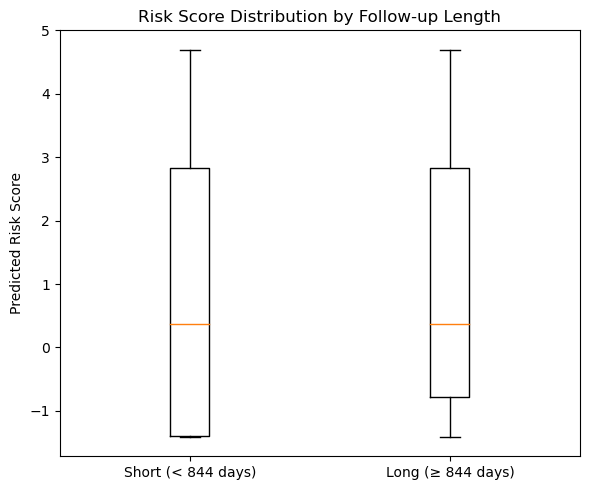

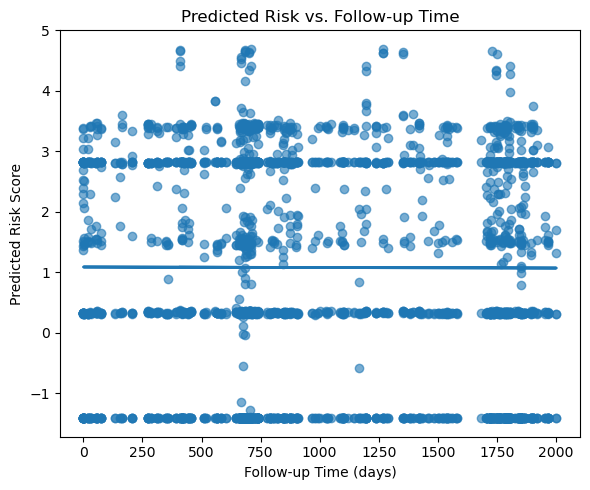

Spearman correlation: ρ = -0.001, p = 0.959


In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from statistics import mean, stdev
from scipy.stats import spearmanr

from data.multimodal_features_surv import MultimodalCTWSIDatasetSurv
from torch.utils.data import DataLoader
from models.dpe.main_model_nobackbone_surv_new_gcs import MADPENetNoBackbonesSurv

def concordance_index_torch(
    predicted_scores: torch.Tensor,
    event_times: torch.Tensor,
    event_observed: torch.Tensor,
    eps: float = 1e-8,
) -> float:
    """Compute Harrell’s C‐index in pure PyTorch."""
    predicted_scores = predicted_scores.flatten()
    event_times = event_times.flatten()
    event_observed = event_observed.flatten()

    # pairwise differences
    dt = event_times.unsqueeze(0) - event_times.unsqueeze(1)
    ds = predicted_scores.unsqueeze(0) - predicted_scores.unsqueeze(1)

    # valid: earlier event and non‐censored
    valid = (dt < 0) & (event_observed.unsqueeze(0) == 1)
    concordant = (ds > 0) & valid
    tied = (ds.abs() < eps) & valid

    c_sum = concordant.sum(dtype=torch.float32)
    t_sum = tied.sum(dtype=torch.float32)
    v_sum = valid.sum(dtype=torch.float32)

    c_index = (c_sum + 0.5 * t_sum) / (v_sum + eps)
    return c_index.item()


# === Paths & settings ===
folds_dir   = "./models/ckpts/CPTAC_UCEC_titan_medimsight_trainmixed15"
test_path   = "./data/processed/processed_CPTAC_UCEC_test/k=all.tsv"
n_folds     = 4
batch_size  = 4

fold_cindices = []
# to aggregate all test‐set predictions & times
all_hazards = []
all_times   = []
all_events  = []

for fold in range(n_folds):
    print(f"\n=== Evaluating Fold {fold} ===")
    # --- load model checkpoint --- 
    model = MADPENetNoBackbonesSurv(
        rad_input_dim=1024,
        histo_input_dim=768,
        inter_dim=256,
        token_dim=256,
        dim_hider=256
    )
    fold_dir = os.path.join(folds_dir, f"fold_{fold}")
    model_subdir = next(d for d in os.listdir(fold_dir)
                        if os.path.isdir(os.path.join(fold_dir, d)))
    ckpt_file = next(f for f in os.listdir(os.path.join(fold_dir, model_subdir))
                     if f.endswith("best_histo_missing.pth"))
    ckpt = torch.load(os.path.join(fold_dir, model_subdir, ckpt_file))
    model.load_state_dict(ckpt["model_state_dict"])
    model.eval()

    # --- prepare test DataLoader ---
    test_ds = MultimodalCTWSIDatasetSurv(
        fold=0,
        split="train",
        ct_path="../MedImageInsights/embeddings_cptacucec",
        wsi_path="../../trident_processed_UCEC_titan/20x_512px_0px_overlap/slide_features_titan",
        labels_splits_path=test_path,
        missing_modality_prob=0.0,
        require_both_modalities=False,
        pairing_mode="one_to_one",
        allow_repeats=True,
        pairs_per_patient=None
    )
    test_loader = DataLoader(test_ds, batch_size=batch_size,
                             shuffle=False, num_workers=0, pin_memory=True)

    # --- inference & c‐index per batch ---
    hazards_fold = []
    times_fold   = []
    events_fold  = []
    batch_cidxs  = []

    with torch.no_grad():
        for batch in test_loader:
            # predicted hazards (we negate to turn risk into score)
            hazard = -model(batch["ct_feature"],
                            batch["wsi_feature"],
                            batch["modality_mask"])["hazard"].squeeze()
            times  = batch["survtime"]
            events = batch["censor"]

            # accumulate numpy arrays
            h_np = hazard.cpu().numpy().ravel()
            t_np = times.cpu().numpy().ravel()
            e_np = events.cpu().numpy().ravel()

            hazards_fold.append(h_np)
            times_fold.append(t_np)
            events_fold.append(e_np)

            # per‐batch c‐index
            cidx = concordance_index_torch(
                predicted_scores=hazard,
                event_times=times,
                event_observed=events
            )
            batch_cidxs.append(cidx)

    # concatenate fold arrays
    hazards_fold = np.concatenate(hazards_fold)
    times_fold   = np.concatenate(times_fold)
    events_fold  = np.concatenate(events_fold)

    # compute fold mean C‐index
    fold_mean = mean(batch_cidxs)
    fold_cindices.append(fold_mean)
    print(f"Fold {fold} mean C‐Index = {fold_mean:.4f}")

    # aggregate across folds
    all_hazards.append(hazards_fold)
    all_times.append(times_fold)
    all_events.append(events_fold)

# concatenate all folds
all_hazards = np.concatenate(all_hazards)
all_times   = np.concatenate(all_times)
all_events  = np.concatenate(all_events)

# overall C‐index summary
overall_mean = mean(fold_cindices)
overall_std  = stdev(fold_cindices)
print(f"\nOverall Mean C‐Index across {n_folds} folds: {overall_mean:.4f} ± {overall_std:.4f}")


# === Risk‐Group Distribution Plots ===

# split by median follow-up time
median_time = np.median(all_times)
short_idx = all_times < median_time
long_idx  = all_times >= median_time

# Boxplot: short vs. long follow-up
plt.figure(figsize=(6,5))
data = [all_hazards[short_idx], all_hazards[long_idx]]
labels = [f"Short (< {median_time:.0f} days)",
          f"Long (≥ {median_time:.0f} days)"]
plt.boxplot(data, labels=labels, showfliers=False)
plt.ylabel("Predicted Risk Score")
plt.title("Risk Score Distribution by Follow-up Length")
plt.tight_layout()
plt.show()

# Scatter + Trendline
plt.figure(figsize=(6,5))
plt.scatter(all_times, all_hazards, alpha=0.6)
# fit linear trend
m, b = np.polyfit(all_times, all_hazards, 1)
plt.plot(all_times, m*all_times + b, linewidth=2)
plt.xlabel("Follow-up Time (days)")
plt.ylabel("Predicted Risk Score")
plt.title("Predicted Risk vs. Follow-up Time")
plt.tight_layout()
plt.show()

# Spearman correlation
rho, pval = spearmanr(all_times, all_hazards)
print(f"Spearman correlation: ρ = {rho:.3f}, p = {pval:.3f}")
